In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kalesahil","key":"06f52e0fbf5b91f814a3dffb9c4ee7a1"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d puneet6060/intel-image-classification

 99% 342M/346M [00:01<00:00, 222MB/s]
100% 346M/346M [00:01<00:00, 220MB/s]


In [6]:
! unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [7]:
#Importing the neccessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils #dataset loading, model visualization
from tensorflow.keras.utils import model_to_dot #graphical representation of a Keras model as a Graphviz dot graph.
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

Train

In [8]:
#Reading images
df_train = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_train/seg_train",
    labels='inferred', # labels from directory
    label_mode='int', #Encode labels as int [0,1...,6]
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 14034 files belonging to 6 classes.


In [9]:
df_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing

In [10]:
df_test = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_test/seg_test",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3000 files belonging to 6 classes.


In [11]:
df_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
# getting class names of training data
class_names = df_train.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [18]:
# Dictionary comprehension
class_count = {class_name: 0 for class_name in class_names}
# initially assign 0 to each class name
class_count

{'buildings': 0,
 'forest': 0,
 'glacier': 0,
 'mountain': 0,
 'sea': 0,
 'street': 0}

In [19]:
for _, labels in df_train: #_ : placeholder
  for label in labels.numpy(): # converts tensor into numpy and iterating over labels
    class_name = class_names[label]
    class_count[class_name] += 1

In [20]:
for class_name, count in class_count.items():
  print(f"{class_name}: {count}")

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [21]:

cls = pd.DataFrame(df_train.class_names).reset_index()
cls.rename(columns={'index': 'label', 0: 'class_name'}, inplace = True)
cls['class_name']=cls["class_name"].str.title()
cls['count']=class_count.values()
cls

,label,class_name,count
0,0,Buildings,2191
1,1,Forest,2271
2,2,Glacier,2404
3,3,Mountain,2512
4,4,Sea,2274
5,5,Street,2382


In [22]:
#converting the dataset to a NumPy iterator which allows iterate over dataset
data_iterator = df_train.as_numpy_iterator()

In [23]:
batch =data_iterator.next() #returns 2 things: batch[0]-> Images and batch[1]-> Labels

In [24]:
for image_batch, labels_batch in df_train:
    print(image_batch.shape) # batch_size, image size, channels(rgb)
    print(labels_batch.shape) # batch size
    break

(32, 150, 150, 3)
(32,)


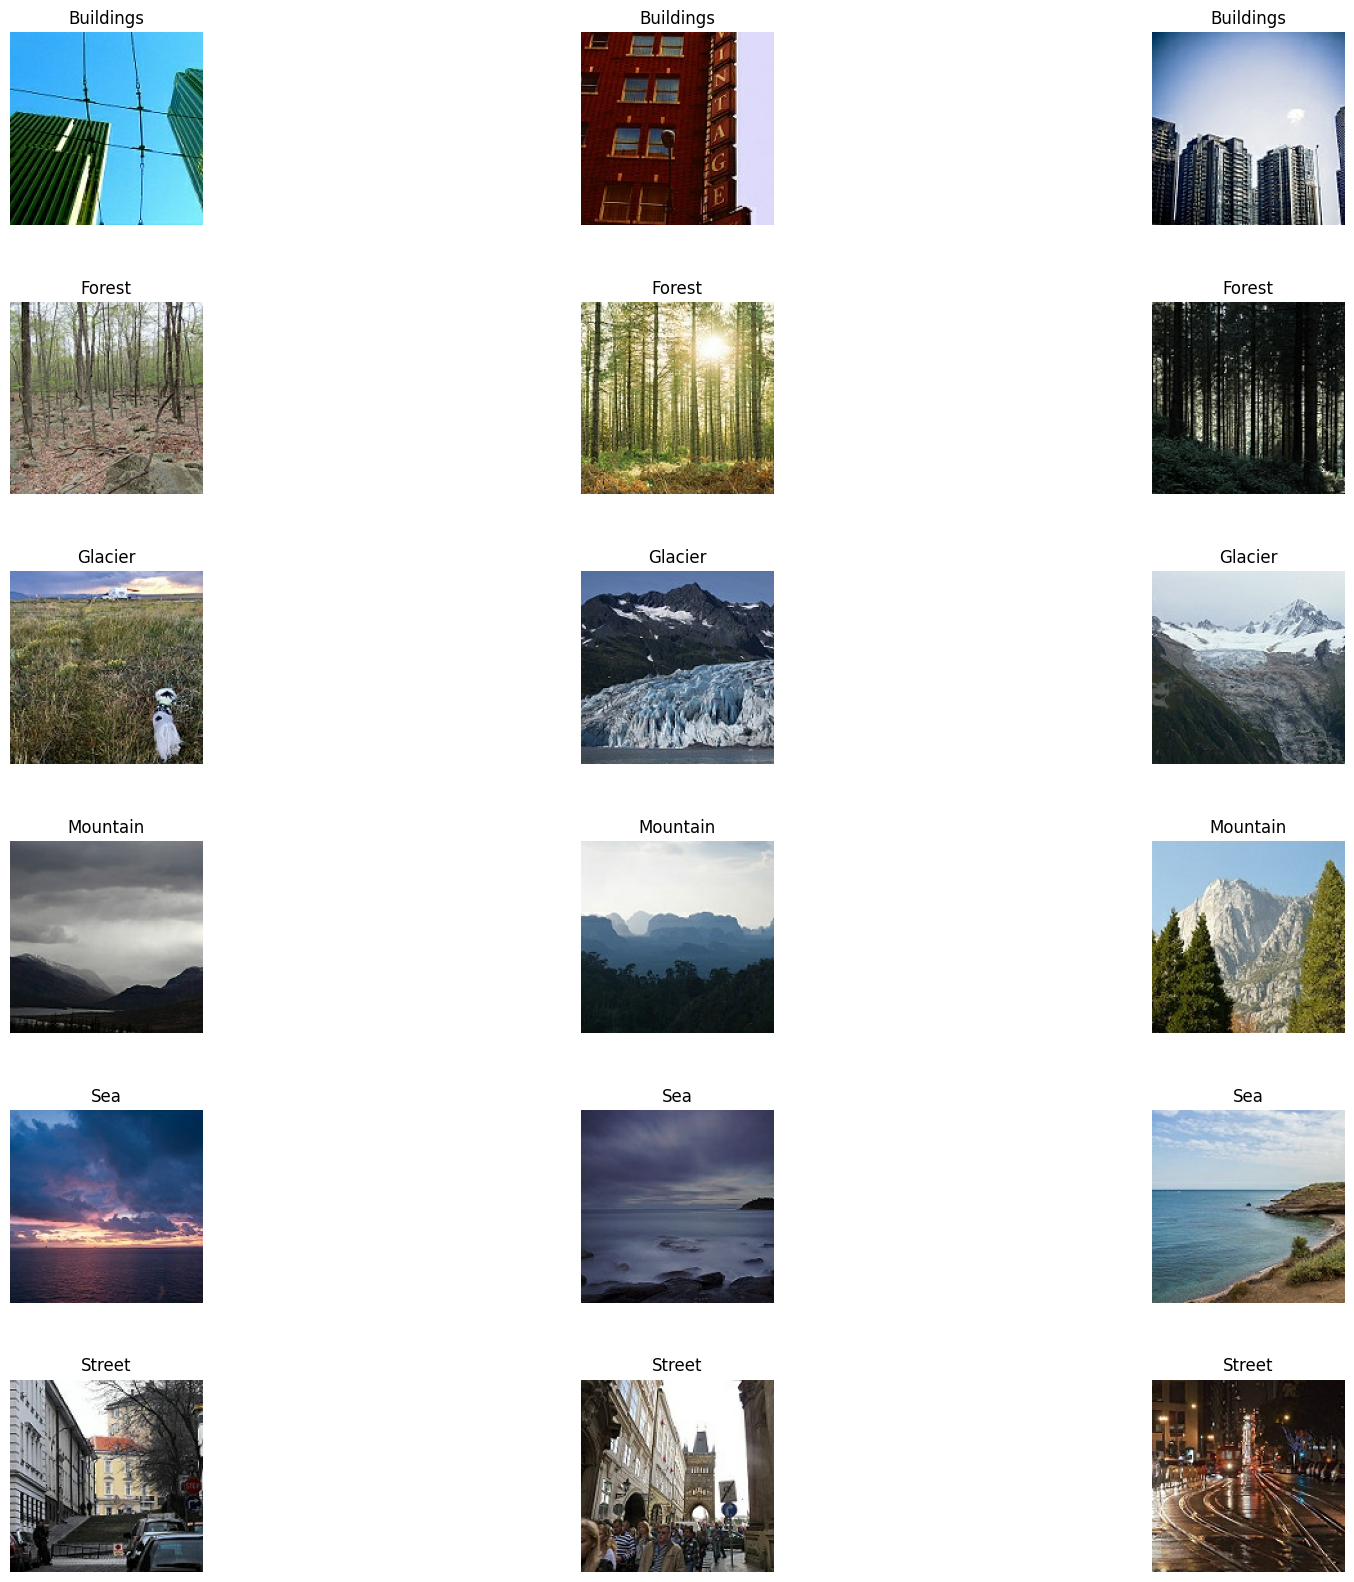

In [25]:
# fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 10)) # creating subplot array
# for i in range(4):
#     for j in range(5):
#         index = i * 4 + j
#         ax[i, j].imshow(batch[0][index].astype(int)) # print images
#         ax[i, j].set_title(cls["class_name"][batch[1][index]]) # print associated titles
#         ax[i,j].axis('off') # no axis
# plt.subplots_adjust(wspace=0.4, hspace=0.4)
# plt.show()

fig, ax = plt.subplots(nrows=len(cls["class_name"]), ncols=3, figsize=(20, 20)) # creating subplot array with number of rows equal to the number of classes

for i, class_name in enumerate(cls["class_name"]):
    # Find the indices of images in the batch that belong to the current class
    indices = np.where(batch[1] == i)[0][:3]  # Select first 5 images for each class
    for j, index in enumerate(indices):
        ax[i, j].imshow(batch[0][index].astype(int)) # print image
        ax[i, j].set_title(class_name) # print associated title
        ax[i, j].axis('off') # no axis

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [26]:
model = Models.Sequential()

#Convolution
model.add(Layers.Conv2D(200, kernel_size=(5,5),activation='relu',input_shape=(150,150,3)))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())

#ANN
model.add(Layers.Dense(180,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer = Optimizer.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 200)     15200     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 200)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 168200)            0         
                                                                 
 dense (Dense)               (None, 180)               30276180  
                                                                 
 dense_1 (Dense)             (None, 6)                 1086      
                                                                 
Total params: 30292466 (115.56 MB)
Trainable params: 30292466 (115.56 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [27]:
trained = model.fit(df_train, validation_data = df_test, validation_split=0.3, batch_size = 32, epochs =1)

439/439 [==============================] - 28s 55ms/step - loss: 38.6251 - accuracy: 0.2817 - val_loss: 1.7767 - val_accuracy: 0.3130


In [28]:
model.save("cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


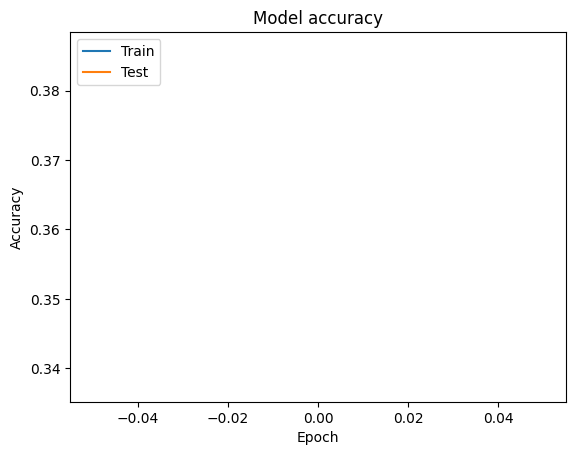

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

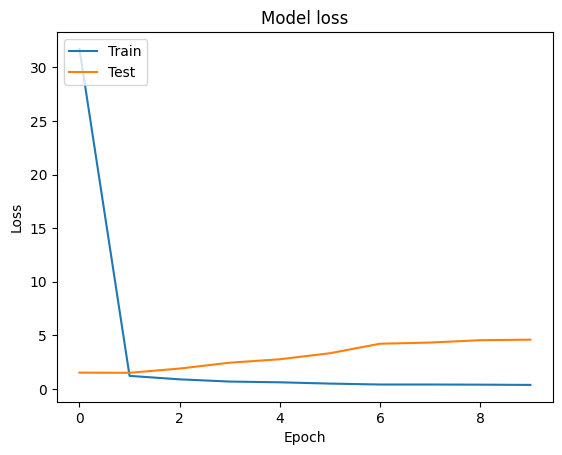

In [ ]:
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
model2 = Models.Sequential()

#Convolution
model2.add(Layers.Conv2D(200, kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model2.add(Layers.Conv2D(180, kernel_size=(3,3),activation='relu'))
model2.add(Layers.MaxPool2D(3,3))
model2.add(Layers.Flatten())

#ANN
model2.add(Layers.Dense(180,activation='relu'))
model2.add(Layers.Dense(120,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model2.add(Layers.Dense(6,activation='softmax'))

model2.compile(optimizer = Optimizer.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 200)     5600      
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 180)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 414720)            0         
                                                                 
 dense_2 (Dense)             (None, 180)               74649780  
                                                                 
 dense_3 (Dense)             (None, 120)               21720     
                                                      

In [ ]:
trained2 = model2.fit(df_train, validation_data = df_test, validation_split=0.3, batch_size=32, epochs =10)

Epoch 1/10
439/439 [==============================] - 152s 319ms/step - loss: 19.0162 - accuracy: 0.2774 - val_loss: 1.5409 - val_accuracy: 0.3993
Epoch 2/10
439/439 [==============================] - 131s 299ms/step - loss: 1.3262 - accuracy: 0.4491 - val_loss: 1.4730 - val_accuracy: 0.3733
Epoch 3/10
439/439 [==============================] - 135s 308ms/step - loss: 0.9295 - accuracy: 0.6231 - val_loss: 1.4151 - val_accuracy: 0.4643
Epoch 4/10
439/439 [==============================] - 131s 298ms/step - loss: 0.6445 - accuracy: 0.7442 - val_loss: 1.9591 - val_accuracy: 0.4517
Epoch 5/10
439/439 [==============================] - 131s 298ms/step - loss: 0.5050 - accuracy: 0.8052 - val_loss: 2.6553 - val_accuracy: 0.4527
Epoch 6/10
439/439 [==============================] - 131s 298ms/step - loss: 0.4149 - accuracy: 0.8387 - val_loss: 2.8890 - val_accuracy: 0.4520
Epoch 7/10
439/439 [==============================] - 131s 297ms/step - loss: 0.3866 - accuracy: 0.8539 - val_loss: 3.2177 

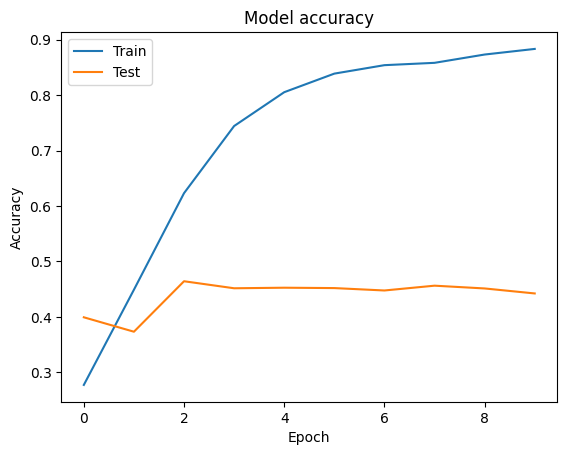

In [ ]:
plt.plot(trained2.history['accuracy'])
plt.plot(trained2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

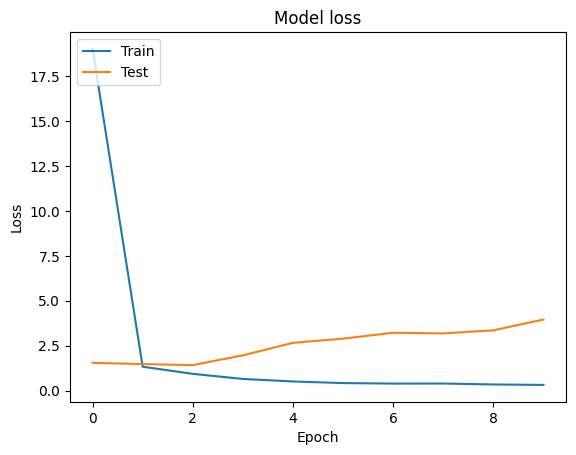

In [ ]:
plt.plot(trained2.history['loss'])
plt.plot(trained2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model3 = Models.Sequential()

#Convolution
model3.add(Layers.Conv2D(200, kernel_size=(3,3),activation='tanh',input_shape=(150,150,3)))
model3.add(Layers.Conv2D(180, kernel_size=(3,3),activation='tanh'))

model3.add(Layers.MaxPool2D(3,3))
model3.add(Layers.Conv2D(160, kernel_size=(3,3),activation='tanh'))
model3.add(Layers.Conv2D(140, kernel_size=(3,3),activation='tanh'))

model3.add(Layers.MaxPool2D(3,3))
model3.add(Layers.Flatten())

#ANN
model3.add(Layers.Dense(180,activation='tanh'))
model3.add(Layers.Dropout(rate=0.5))
model3.add(Layers.Dense(120,activation='tanh'))
model3.add(Layers.Dense(60,activation='tanh'))

#O/P Layer 6 becuase - 6 classes
model3.add(Layers.Dense(6,activation='softmax'))

model3.compile(optimizer = Optimizer.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 200)     5600      
                                                                 
 conv2d_4 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 180)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 160)       259360    
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 140)       201740    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 140)       0         
 g2D)                                                 

In [ ]:
trained3 = model3.fit(df_train, validation_data = df_test, validation_split=0.3, batch_size=100, epochs =5)

Epoch 1/5
439/439 [==============================] - 169s 384ms/step - loss: 1.7983 - accuracy: 0.1722 - val_loss: 1.7954 - val_accuracy: 0.1843
Epoch 2/5
439/439 [==============================] - 156s 355ms/step - loss: 1.7963 - accuracy: 0.1756 - val_loss: 1.7976 - val_accuracy: 0.1843
Epoch 3/5
439/439 [==============================] - 156s 354ms/step - loss: 1.7969 - accuracy: 0.1756 - val_loss: 1.7964 - val_accuracy: 0.1670
Epoch 4/5
439/439 [==============================] - 156s 355ms/step - loss: 1.7970 - accuracy: 0.1699 - val_loss: 1.7930 - val_accuracy: 0.1843
Epoch 5/5
439/439 [==============================] - 156s 354ms/step - loss: 1.7960 - accuracy: 0.1755 - val_loss: 1.7927 - val_accuracy: 0.1843


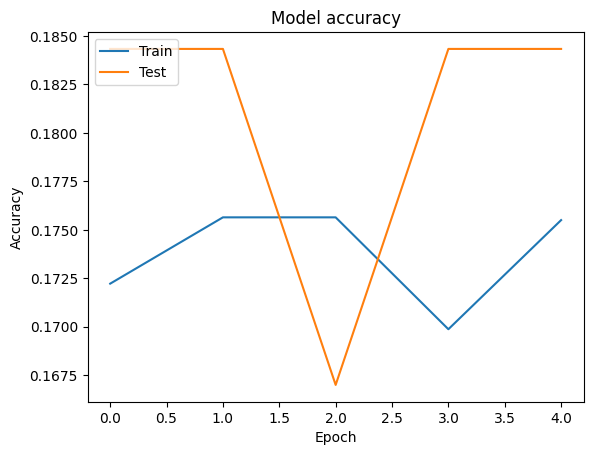

In [ ]:
plt.plot(trained3.history['accuracy'])
plt.plot(trained3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

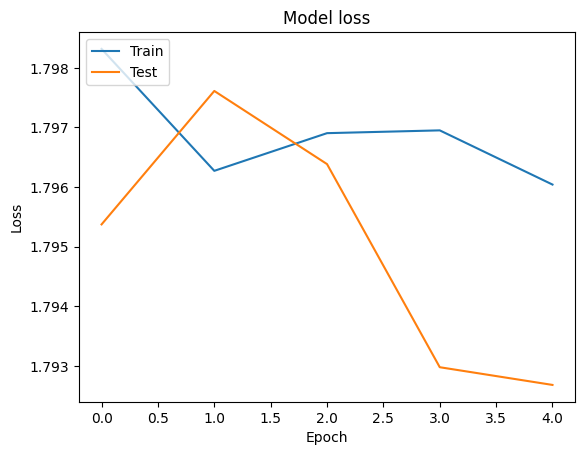

In [ ]:
plt.plot(trained3.history['loss'])
plt.plot(trained3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model4 = Models.Sequential()

#Convolution
model4.add(Layers.Conv2D(200, kernel_size=(5,5),activation='leaky_relu',input_shape=(150,150,3)))
model4.add(Layers.Conv2D(150, kernel_size=(5,5),activation='leaky_relu'))
model4.add(Layers.MaxPool2D(5,5))
model4.add(Layers.BatchNormalization(axis=-1))

model4.add(Layers.Conv2D(150, kernel_size=(3,3),activation='leaky_relu'))
model4.add(Layers.Conv2D(100, kernel_size=(3,3),activation='leaky_relu'))
model4.add(Layers.MaxPool2D(3,3))
model4.add(Layers.BatchNormalization(axis=-1))


model4.add(Layers.Flatten())

#ANN
model4.add(Layers.Dense(200,activation='leaky_relu'))
model4.add(Layers.Dropout(rate=0.2))
model4.add(Layers.Dense(150,activation='leaky_relu'))
model4.add(Layers.Dropout(rate=0.1))
model4.add(Layers.Dense(100,activation='leaky_relu'))

#O/P Layer 6 becuase - 6 classes
model4.add(Layers.Dense(6,activation='softmax'))

model4.compile(optimizer = Optimizer.Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 200)     15200     
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 142, 150)     750150    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 150)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 28, 28, 150)       600       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 150)       202650    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 100)       1

In [ ]:
trained4 = model4.fit(df_train, validation_data = df_test,validation_split=0.3, batch_size=50, epochs =10)

Epoch 1/10
439/439 [==============================] - 201s 398ms/step - loss: 0.8726 - accuracy: 0.6658 - val_loss: 1.2304 - val_accuracy: 0.5930
Epoch 2/10
439/439 [==============================] - 156s 355ms/step - loss: 0.5974 - accuracy: 0.7829 - val_loss: 0.7247 - val_accuracy: 0.7470
Epoch 3/10
439/439 [==============================] - 156s 356ms/step - loss: 0.4809 - accuracy: 0.8247 - val_loss: 0.4892 - val_accuracy: 0.8273
Epoch 4/10
439/439 [==============================] - 157s 357ms/step - loss: 0.3985 - accuracy: 0.8561 - val_loss: 0.5939 - val_accuracy: 0.8000
Epoch 5/10
439/439 [==============================] - 166s 378ms/step - loss: 0.3335 - accuracy: 0.8793 - val_loss: 0.5204 - val_accuracy: 0.8213
Epoch 6/10
439/439 [==============================] - 156s 356ms/step - loss: 0.2785 - accuracy: 0.9003 - val_loss: 0.4511 - val_accuracy: 0.8487
Epoch 7/10
439/439 [==============================] - 156s 355ms/step - loss: 0.2253 - accuracy: 0.9196 - val_loss: 0.4702 -

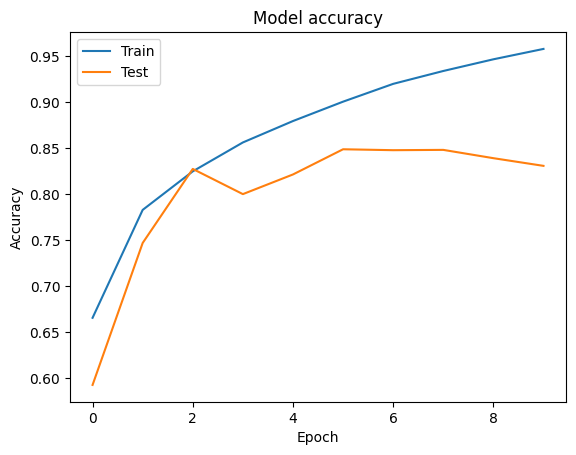

In [ ]:
plt.plot(trained4.history['accuracy'])
plt.plot(trained4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

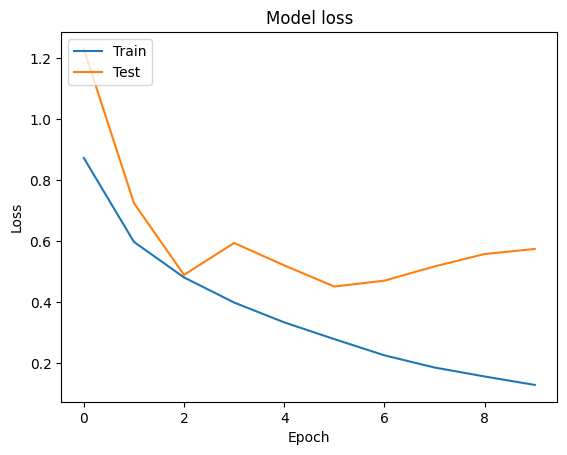

In [ ]:
plt.plot(trained4.history['loss'])
plt.plot(trained4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model5 = Models.Sequential()

#Convolution
model5.add(Layers.Conv2D(100, kernel_size=(5,5),activation='relu',input_shape=(150,150,3)))
model5.add(Layers.Conv2D(80,kernel_size=(5,5),activation ='relu'))
model5.add(Layers.MaxPool2D(5,5))

model5.add(Layers.BatchNormalization(axis=-1))

model5.add(Layers.Conv2D(150, kernel_size=(3,3),activation='relu'))
model5.add(Layers.Conv2D(100, kernel_size=(3,3),activation='relu'))
model5.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model5.add(Layers.MaxPool2D(3,3))

model5.add(Layers.BatchNormalization(axis=-1))

model5.add(Layers.Flatten())

#ANN
model5.add(Layers.Dense(150,activation='relu'))
model5.add(Layers.Dropout(rate=0.25))
model5.add(Layers.Dense(100,activation='relu'))
model5.add(Layers.Dropout(rate=0.1))
model5.add(Layers.Dense(50,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model5.add(Layers.Dense(6,activation='softmax'))

model5.compile(optimizer = Optimizer.Adam(lr = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model5.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7979a87e82e0>>

In [ ]:
trained5 = model5.fit(df_train, validation_data = df_test,validation_split=0.3, batch_size=50, epochs =30)

Epoch 1/30
439/439 [==============================] - 73s 139ms/step - loss: 1.0519 - accuracy: 0.6000 - val_loss: 0.8619 - val_accuracy: 0.6710
Epoch 2/30
439/439 [==============================] - 53s 120ms/step - loss: 0.7488 - accuracy: 0.7256 - val_loss: 0.9476 - val_accuracy: 0.6450
Epoch 3/30
439/439 [==============================] - 52s 119ms/step - loss: 0.6262 - accuracy: 0.7738 - val_loss: 1.6084 - val_accuracy: 0.5173
Epoch 4/30
439/439 [==============================] - 53s 120ms/step - loss: 0.5499 - accuracy: 0.8071 - val_loss: 1.0830 - val_accuracy: 0.6203
Epoch 5/30
439/439 [==============================] - 53s 121ms/step - loss: 0.5014 - accuracy: 0.8209 - val_loss: 0.5586 - val_accuracy: 0.7980
Epoch 6/30
439/439 [==============================] - 52s 118ms/step - loss: 0.4620 - accuracy: 0.8358 - val_loss: 0.9416 - val_accuracy: 0.7220
Epoch 7/30
439/439 [==============================] - 53s 121ms/step - loss: 0.4241 - accuracy: 0.8487 - val_loss: 0.7801 - val_ac

In [ ]:
plt.plot(trained4.history['accuracy'])
plt.plot(trained4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(trained4.history['loss'])
plt.plot(trained4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)


In [29]:
# Function for predicting the image
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)

    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(str(class_names[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 321ms/step


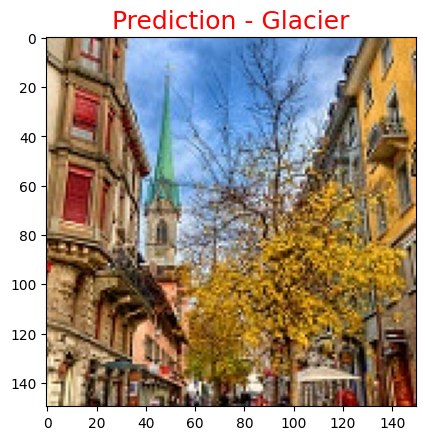

In [30]:
from tensorflow.keras.preprocessing import image
predict_image('/content/seg_pred/seg_pred/10004.jpg', model)


In [45]:
pip install gradio==3.50

  Using cached gradio-3.50.0-py3-none-any.whl (20.3 MB)


In [46]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [47]:
model_path = "/content/cnn_model.h5"

# Load the saved model
loaded_model = load_model(model_path)

In [48]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [49]:
def classify_img(img):
  img = img.reshape(-1,150,150,3)
  prediction = loaded_model.predict(img)[0]
  return {class_names[i]: float(prediction[i]) for i in range(6)}

In [51]:
image = gr.Image(shape=(150,150))
label = gr.outputs.Label(num_top_classes=6)

gr.Interface(fn=classify_img, inputs=image, outputs=label, capture_session=True).launch(debug=True)

AttributeError: module 'gradio' has no attribute 'inputs'